In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/_Fish.csv


In [102]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset

In [103]:
data=pd.read_csv('../input/_Fish.csv')
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [104]:
len(data)

159

In [105]:
input_cols=['Weight','Length1','Length2','Length3','Height','Width']
input_cols

['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']

In [107]:
output_cols=['Species']
output_cols

['Species']

In [108]:
num_rows=data.shape[0]
num_rows

159

In [109]:
num_cols=data.shape[1]
num_cols

7

In [110]:
categorical_cols=list(data.select_dtypes(include=['object']).columns)
categorical_cols

['Species']

In [111]:
def dataframe_to_array(data):
    
    # copy of the data is created
    dataframe=data.copy(deep=True)
    
    # converting non_numrical datas into codes
    for col in categorical_cols:
        dataframe[col]=dataframe[col].astype('category').cat.codes
        
    # converting input_data to numpy array
    inputs_array = dataframe[input_cols].to_numpy()
    
    # converting output_data to numpy array
    targets_array = dataframe[output_cols].to_numpy()
    
    return inputs_array,targets_array

In [112]:
# for col in categorical_cols:
        # data[col]=data[col].astype('category').cat.codes
# data['Species'].dtype
# targets_array = data['Weight'].to_numpy()
# targets_array,targets_array.dtype



In [113]:
inputs_array,targets_array = dataframe_to_array(data)
inputs_array,targets_array

(array([[2.42000e+02, 2.32000e+01, 2.54000e+01, 3.00000e+01, 1.15200e+01,
         4.02000e+00],
        [2.90000e+02, 2.40000e+01, 2.63000e+01, 3.12000e+01, 1.24800e+01,
         4.30560e+00],
        [3.40000e+02, 2.39000e+01, 2.65000e+01, 3.11000e+01, 1.23778e+01,
         4.69610e+00],
        [3.63000e+02, 2.63000e+01, 2.90000e+01, 3.35000e+01, 1.27300e+01,
         4.45550e+00],
        [4.30000e+02, 2.65000e+01, 2.90000e+01, 3.40000e+01, 1.24440e+01,
         5.13400e+00],
        [4.50000e+02, 2.68000e+01, 2.97000e+01, 3.47000e+01, 1.36024e+01,
         4.92740e+00],
        [5.00000e+02, 2.68000e+01, 2.97000e+01, 3.45000e+01, 1.41795e+01,
         5.27850e+00],
        [3.90000e+02, 2.76000e+01, 3.00000e+01, 3.50000e+01, 1.26700e+01,
         4.69000e+00],
        [4.50000e+02, 2.76000e+01, 3.00000e+01, 3.51000e+01, 1.40049e+01,
         4.84380e+00],
        [5.00000e+02, 2.85000e+01, 3.07000e+01, 3.62000e+01, 1.42266e+01,
         4.95940e+00],
        [4.75000e+02, 2.84000e

In [114]:
# converting_numpy_array to Tensor

inputs=torch.from_numpy(inputs_array).type(torch.float32)
targets=torch.from_numpy(targets_array).type(torch.float32)
inputs.dtype

torch.float32

In [115]:
# creating dataset
dataset=TensorDataset(inputs,targets)

val_per=0.1
val_size=int(num_rows*val_per)
train_size=num_rows-val_size

# to split dataset into training and validataion dataset
train_ds,val_ds = random_split(dataset,(train_size,val_size))
len(train_ds),len(val_ds)

(144, 15)

In [116]:
# now we want to make dataloader
batch_size=32
train_dl=DataLoader(train_ds,batch_size,shuffle=True)
val_dl=DataLoader(val_ds,batch_size)

In [117]:
#for xb,yb in train_dl:
    #print(xb)
    #print(yb)

In [118]:
input_size=len(input_cols)
output_size=len(output_cols)

In [119]:
class Fish(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(input_size,output_size)
    def forward(self,ins):
        out = self.linear(ins)
        return out
    def training_step(self,batch):
        inputs,targets=batch
        out=self(inputs)
        loss=F.l1_loss(out,targets)
        return loss
    def validation_step(self,batch):
        inputs,targets=batch
        out=self(inputs)
        loss=F.l1_loss(out,targets)
        return {'val_loss':loss.detach()}
    def validation_epoch(self,output):
        batch_loss=[x['val_loss'] for x in output]
        epoch_loss=torch.stack(batch_loss).mean()
        return {'val_loss':epoch_loss.item()}
    def epoch_end(self,epoch,result,num_epochs):
        # Printing epoch at every 20 steps
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [120]:
model = Fish()
list(model.parameters())

[Parameter containing:
 tensor([[-0.3268,  0.2559,  0.2764, -0.2743,  0.3657,  0.2953]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3477], requires_grad=True)]

In [121]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [122]:
result=evaluate(model,val_dl)
result

{'val_loss': 156.4636688232422}

###  Train the model 4-5 times  its a simple model so train with different learning rates & for different number of epochs.

In [123]:
epochs = 100
lr = 1e-6
history1 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [20], val_loss: 136.4420
Epoch [40], val_loss: 116.2336
Epoch [60], val_loss: 96.3101
Epoch [80], val_loss: 76.3094
Epoch [100], val_loss: 56.3021


In [124]:
epochs = 100
lr = 1e-5
history2= fit(epochs, lr, model, train_dl, val_dl)

Epoch [20], val_loss: 2.6513
Epoch [40], val_loss: 2.3134
Epoch [60], val_loss: 2.1430
Epoch [80], val_loss: 1.8424
Epoch [100], val_loss: 1.6982


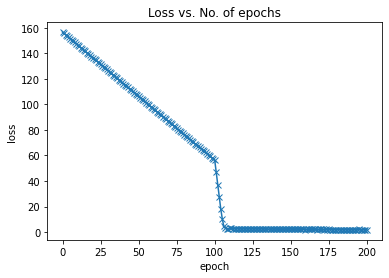

In [125]:
val_loss = [result]+history1+history2
val_loss_list = [vl['val_loss'] for vl in val_loss]
plt.plot(val_loss_list, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [126]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    
input, target = val_ds[0]
predict_single(input, target, model)
input, target = val_ds[1]
predict_single(input, target, model)
input, target = val_ds[2]
predict_single(input, target, model)
input, target = val_ds[3]
predict_single(input, target, model)
input, target = val_ds[4]
predict_single(input, target, model)

Input: tensor([1000.0000,   33.5000,   37.0000,   42.6000,   18.9570,    6.6030])
Target: tensor([0.])
Prediction: tensor([-1.2959])
